In [1]:
# Importando a biblioteca PyTorch para cálculos com tensores
import torch
# Importando a biblioteca Matplotlib para plotagem de gráficos
import matplotlib.pyplot as plt
# Importando a classe FuncAnimation da Matplotlib para animações
from matplotlib.animation import FuncAnimation
# Importando a biblioteca NumPy, que oferece funcionalidades numéricas em Python
import numpy as np

## SGD in Pytorch

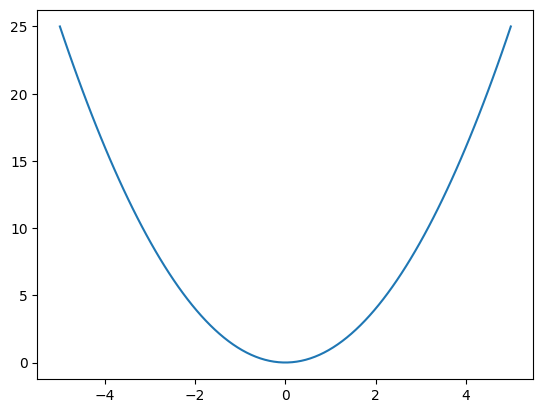

In [2]:
# Definindo a função f(x) = x^2
f = lambda x: x**2

# Definindo os limites inferior (lb) e superior (ub) para o intervalo de x
lb, ub = -5.0, 5.0

# Criando um vetor de 100 pontos igualmente espaçados no intervalo [lb, ub]
x = torch.linspace(lb, ub, 100)

# Aplicando a função f sobre o vetor x para obter o vetor y
y = f(x)

# Plotando o gráfico de y = f(x) com x no eixo horizontal e y no eixo vertical
plt.plot(x, y)
# Exibindo o gráfico gerado
plt.show()

In [3]:
# Declarando o tensor x_star com valor inicial -3.0 e configurando para calcular o gradiente
x_star = torch.tensor([-3.0], requires_grad=True)

# Criando o otimizador SGD (Descent Gradient Stochastic) para otimizar o tensor x_star
# A taxa de aprendizado (lr) é definida como 0.01
opt = torch.optim.SGD([x_star], lr=0.01)

# Definindo o número de iterações que o otimizador fará
iters = 200

# Criando um vetor para armazenar a trajetória de valores de x_star durante as iterações
x_traj = torch.zeros(iters)

# Imprimindo o valor da função f(x_star) antes de iniciar a otimização
print("Before optimization: ", f(x_star))

# Loop de otimização: realiza 200 iterações para minimizar a função f(x)
for i in range(iters):
    # Zera os gradientes calculados nas iterações anteriores
    opt.zero_grad()

    # Calcula a função perda (loss), que é o valor de f(x_star)
    loss = f(x_star)

    # Calcula o gradiente da função de perda em relação a x_star
    loss.backward()

    # Atualiza o valor de x_star com base no gradiente calculado
    opt.step()

    # Armazena o valor de x_star após a iteração no vetor x_traj
    x_traj[i] = x_star.detach()

# Imprime o valor de f(x_star) após as iterações de otimização
print("After optimization: ", f(x_star))

# Converte a trajetória de valores de x_traj para um formato de array NumPy
x_traj = x_traj.numpy()

# Calcula o valor de y_traj aplicando a função f nos valores de x_traj
y_traj = f(x_traj)

Before optimization:  tensor([9.], grad_fn=<PowBackward0>)
After optimization:  tensor([0.0028], grad_fn=<PowBackward0>)


IndexError: list index out of range

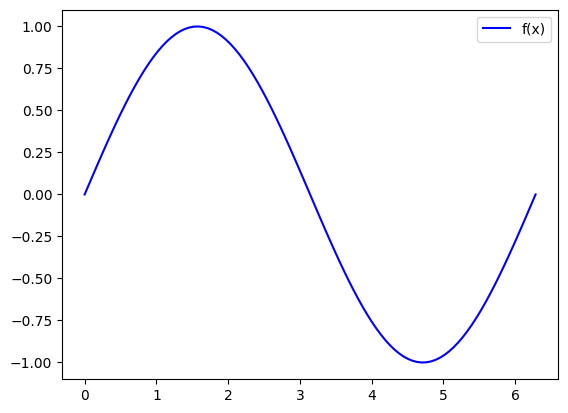

In [14]:
fig, ax = plt.subplots()
ax.plot(x, y, 'b-', label=f'f(x)')
point, = ax.plot([], [], 'ro', markersize=10)  # Point to animate
ax.legend()

# Initialize and update functions for the animation
def init():
    point.set_data([], [])
    return point,

def update(frame):
    point.set_data(x_traj[frame], y_traj[frame])
    return point,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(x_traj), init_func=init, blit=True, repeat=True)

# Save the animation as a GIF
ani.save('sgd_trajectory.gif', writer='pillow', fps=10)

## Exemplo simples de VI

In [6]:
# Definindo o valor verdadeiro dos parâmetros theta
true_theta = torch.tensor([1.0, 1.0])

# Definindo o número de dados que serão gerados
num_data = 1000

# Criando um tensor x com duas colunas:
# A primeira coluna é composta por números aleatórios com distribuição normal (média 0 e desvio padrão 1)
# A segunda coluna é composta por números 1 (todas as entradas são 1)
x = torch.cat((torch.randn(num_data, 1), torch.ones(num_data, 1)), dim=-1)

# Calculando os logits, ou seja, a combinação linear de x e true_theta.
# O operador "@" realiza a multiplicação de matriz (produto escalar), e true_theta[:, None] transforma o vetor em uma coluna
logits = x @ true_theta[:, None]

# Gerando os valores de y a partir de uma distribuição de Bernoulli
# Primeiro, aplicamos a função sigmoide aos logits para obter valores no intervalo [0, 1]
# Depois, geramos amostras de Bernoulli (0 ou 1) com base nesses valores
y = torch.bernoulli(torch.nn.functional.sigmoid(logits))

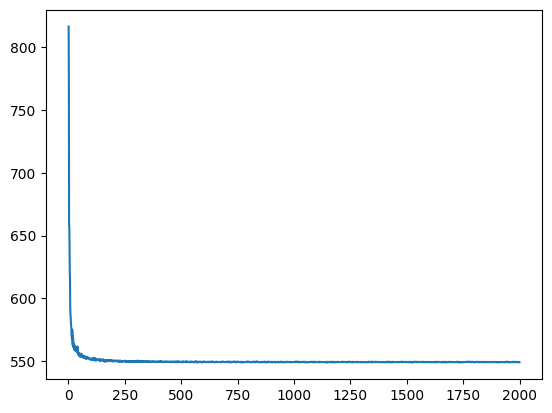

In [7]:
# Definindo a função de perda (negativo da log-verossimilhança) para classificação binária
neg_log_lik = torch.nn.functional.binary_cross_entropy_with_logits

# Definindo a função de priori negativa (prior logarítmico)
# A priori é uma distribuição normal padrão (N(0, I)), então a penalidade é 0.5 * soma dos quadrados dos parâmetros
neg_log_prior = lambda x: 0.5 * (x ** 2).sum(dim=-1)  # up to some additive constant

# Inicializando os parâmetros mu e log_sigma como tensores com gradientes habilitados
# 'mu' representa a média da distribuição e 'log_sigma' representa o log da variância (desvio padrão)
mu = torch.randn(2, requires_grad=True)
log_sigma = torch.randn(2, requires_grad=True)

# Definindo o otimizador SGD para otimizar os parâmetros mu e log_sigma
opt = torch.optim.SGD([mu, log_sigma], lr=0.001)

# Definindo o número de iterações do processo de otimização
iters = 2000

# Definindo o número de amostras Monte Carlo (MC) a ser gerado para cada iteração
num_mc = 100

# Histórico de perdas, para plotar a evolução da função de perda durante as iterações
hist_loss = torch.zeros(iters)

# Loop de otimização
for i in range(iters):
    # Zera os gradientes anteriores
    opt.zero_grad()
    
    # Gera amostras aleatórias a partir de uma distribuição normal padrão
    # z é um tensor de amostras que será escalado por 'log_sigma' e deslocado por 'mu'
    z = torch.randn((num_mc, 2))
    
    # Calculando 'theta', que é a amostra de parâmetros amostrados da distribuição normal com média 'mu' e desvio 'log_sigma'
    theta = z * log_sigma.exp().expand_as(z) + mu.expand_as(z)
    
    # Calculando os logits, que são a multiplicação dos dados de entrada 'x' com os parâmetros 'theta'
    logits = x @ theta.T  # Transposta de 'theta' para multiplicação de matriz correta
    
    # Calculando a função de perda negativa logarítmica combinada com a priori
    # A primeira parte calcula a log-verossimilhança com logits e y
    # A segunda parte adiciona a penalização pela priori dos parâmetros 'theta'
    neg_log_joint = neg_log_lik(logits, y.expand_as(logits), reduction='none').sum(dim=0) + neg_log_prior(theta)
    
    # Calculando o valor esperado do negativo da log-verossimilhança
    E_neg_log_joint = neg_log_joint.mean()
    
    # Calculando a entropia negativa de 'sigma', que é proporcional à soma de 'log_sigma'
    log_q = - log_sigma.sum()  # negative entropy
    
    # A função de perda é a combinação da expectativa da log-verossimilhança e a entropia negativa
    loss = E_neg_log_joint + log_q
    
    # Calculando os gradientes com relação à perda
    loss.backward()
    
    # Registrando a perda para a iteração atual
    hist_loss[i] = loss.detach()
    
    # Atualizando os parâmetros com base nos gradientes calculados
    opt.step()

# Plotando a evolução da função de perda durante as iterações
plt.plot(torch.arange(1, iters + 1), hist_loss)

In [8]:
# 'mu.detach()' desconecta o tensor 'mu' do grafo computacional.
# Isso significa que, após essa operação, as operações futuras em 'mu' não irão calcular os gradientes,
# o que pode ser útil quando você deseja usar 'mu' para cálculos sem propagar gradientes.
mu.detach()

# 'log_sigma.exp().detach()' faz o mesmo para 'log_sigma':
# Primeiro, ele calcula a exponencial de 'log_sigma' (o que reverte o logaritmo e nos dá o valor de sigma),
# em seguida, 'detach()' desconecta esse valor do grafo computacional, prevenindo o cálculo dos gradientes
# em qualquer operação subsequente usando esse valor.
log_sigma.exp().detach()


tensor([0.0850, 0.0745])

In [9]:
# Função que calcula o logaritmo posterior não normalizado (log_post) de uma distribuição.
# Essa função é utilizada em contextos de inferência bayesiana para calcular a probabilidade 
# de um parâmetro (neste caso, 'theta') dado os dados observados.

def unnormalized_log_post(theta):
    # Calcula a parte 'a' da função de verossimilhança negativa:
    # Aqui, 'x @ theta' realiza um produto escalar entre os dados de entrada 'x' e os parâmetros 'theta'.
    # Esse valor é então passado para a função de perda de log-verossimilhança (neg_log_lik) para calcular o erro de previsão.
    logits = x @ theta
    
    # 'neg_log_lik(logits[:, None], y, reduction='none')' calcula a log-verossimilhança para cada ponto de dados.
    # '[:, None]' é usado para adicionar uma dimensão extra para garantir que a forma da matriz seja compatível com 'y'.
    # 'reduction="none"' significa que a perda não será reduzida (somente retornada para cada ponto de dados, sem média).
    # 'sum(dim=0)' soma as perdas ao longo de todas as observações, resultando na perda total (parte 'a').
    part_a = neg_log_lik(logits[:, None], y, reduction='none').sum(dim=0)
    
    # A parte 'b' é o logaritmo da prior (distribuição a priori) dos parâmetros 'theta'.
    # A função 'neg_log_prior(theta)' calcula a penalização pela escolha dos valores dos parâmetros,
    # de acordo com a distribuição a priori definida.
    part_b = neg_log_prior(theta)
    
    # A soma de 'part_a' e 'part_b' resulta no logaritmo da distribuição a posteriori não normalizada.
    # No entanto, esse valor ainda não está normalizado (não foi dividido pela constante de normalização).
    log_post = part_a + part_b
    
    # A função retorna o valor negativo do logaritmo posterior não normalizado.
    # O valor negativo é utilizado em otimização para minimizar a função de perda durante o treinamento.
    return -log_post



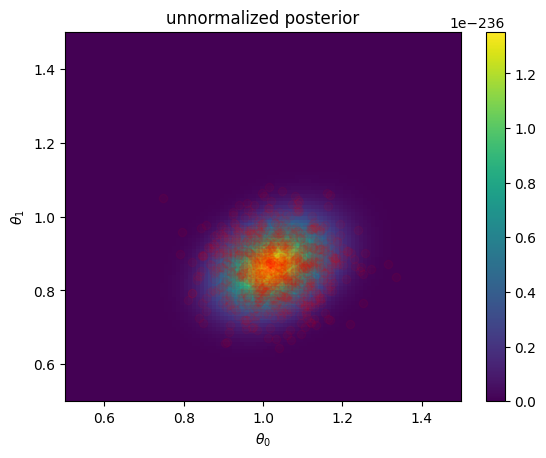

In [10]:
# Gerar pontos da grade para os parâmetros theta0 e theta1
# Aqui, estamos criando uma grade de valores para os parâmetros theta0 e theta1
# que vão variar de 0.5 a 1.5, com 100 pontos em cada direção.
theta0 = np.linspace(0.5, 1.5, 100)  # Geração de 100 valores para theta0 entre 0.5 e 1.5
theta1 = np.linspace(0.5, 1.5, 100)  # Geração de 100 valores para theta1 entre 0.5 e 1.5

# Cria uma grade de pontos (matriz 2D) combinando os valores de theta0 e theta1
Theta0, Theta1 = np.meshgrid(theta0, theta1)  # Gera uma grade 2D dos parâmetros

# Avaliar a função log_post em toda a grade de pontos
# Para cada par de valores (t0, t1) na grade, calculamos o valor do logaritmo posterior não normalizado.
# Isso é feito em duas etapas:
# 1. Iterar sobre as linhas da grade Theta0 e Theta1.
# 2. Para cada par de valores, calcular o valor do log_post, e armazená-lo na matriz 'log_post_values'.
log_post_values = np.array([[unnormalized_log_post(torch.tensor([t0, t1], dtype=torch.float32)).item()
                             for t0, t1 in zip(t0_row, t1_row)]
                            for t0_row, t1_row in zip(Theta0, Theta1)])

# Plotar o gráfico de calor (heatmap) da função log_post
# O gráfico de calor mostra os valores de 'log_post' avaliados sobre a grade de parâmetros theta0 e theta1.
# A função np.exp(log_post_values) é usada para mostrar a versão exponencial dos valores do logaritmo posterior,
# já que estamos interessados nos valores de probabilidade, não nos logaritmos.
fig, ax = plt.subplots()  # Cria a figura e os eixos para o gráfico
heatmap = ax.imshow(np.exp(log_post_values), extent=[0.5, 1.5, 0.5, 1.5], origin='lower', aspect='auto', cmap='viridis')
# A função imshow exibe os valores da matriz 'log_post_values' como uma imagem (gráfico de calor).
# 'extent' define os limites dos eixos, e 'cmap' define a paleta de cores do gráfico de calor.
fig.colorbar(heatmap, ax=ax)  # Adiciona uma barra de cores ao gráfico
ax.set_title('unnormalized posterior')  # Título do gráfico
ax.set_xlabel(r'$\theta_0$')  # Rótulo do eixo X
ax.set_ylabel(r'$\theta_1$')  # Rótulo do eixo Y

# Plotar o gráfico de dispersão (scatter plot) das amostras aproximadas
# Aqui, geramos amostras aproximadas da distribuição posterior usando amostragem de Monte Carlo.
z = torch.randn((1000, 2))  # Gera amostras de uma distribuição normal padrão (média 0 e variância 1)
approx_samples = z * log_sigma.exp().expand_as(z) + mu.expand_as(z)
# As amostras são geradas pela transformação da distribuição normal usando os parâmetros 'mu' (média)
# e 'log_sigma' (desvio padrão), aplicando a transformação exp(log_sigma) para obter o desvio padrão real.

# O .detach() é usado para desconectar essas amostras do grafo computacional, ou seja, impedir que qualquer cálculo futuro
# sobre essas amostras afete o gradiente (não realizamos backpropagation sobre essas amostras).
approx_samples = approx_samples.detach()

# Agora, plotamos as amostras no gráfico de dispersão. O parâmetro 'alpha=0.05' define a transparência dos pontos
# para que eles não sobrecarreguem o gráfico.
ax.scatter(approx_samples[:, 0], approx_samples[:, 1], alpha=0.05, color='red')

# Exibe o gráfico com o gráfico de calor e o gráfico de dispersão sobrepostos.
plt.show()